In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import scipy.stats as stats

from nltk.corpus import stopwords

## 3. Overview Text Prerpocessing

### 3.1. Data load and preprocessing

In [2]:
imdb_data = pd.read_csv("imdb_top_1000.csv")
stopwords_eng = stopwords.words("english")

In [3]:
imdb_data["Gross"] = imdb_data["Gross"].apply(lambda x: float(x.replace(",", "")) if isinstance(x, str) else x)
imdb_data["Released_Year"] = pd.to_datetime(imdb_data["Released_Year"], format="%Y", errors="coerce")
imdb_data["Runtime"] = imdb_data["Runtime"].apply(lambda x: int(x.split()[0]))
imdb_data["Genre"] = imdb_data["Genre"].apply(lambda x: x.split(", "))

### 3.2. Overview preprocessing

We tokenize the Overview column, remove stopwords, punctuation and numerical values.

In [4]:
lemmatizer = nltk.WordNetLemmatizer()

In [5]:
imdb_data["Overview_processed"] = (
    imdb_data["Overview"].apply(lambda x: x.lower()).apply(nltk.word_tokenize)
)
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(
    lambda x: [word for word in x if word not in stopwords_eng]
)
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(
    lambda x: [word for word in x if word.isalnum()]
)
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(
    lambda x: [word for word in x if not any(char.isdigit() for char in word)]
)
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(
    lambda x: [lemmatizer.lemmatize(word) for word in x]
)

### 3.3. Overview length analysis

#### 3.3.1 Length by number of words

In [6]:
imdb_data["Overview_length_words"] = imdb_data["Overview_processed"].apply(len)

<Axes: >

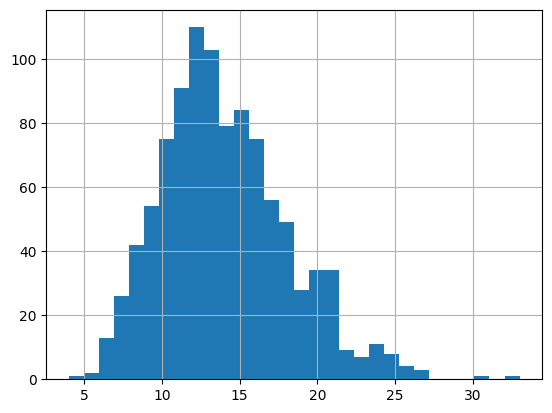

In [7]:
imdb_data["Overview_length_words"].hist(bins=30)

Most overviews have around 12 words after stopword removal. Now exploring the relationship to ratings and scores:

##### Movie rating

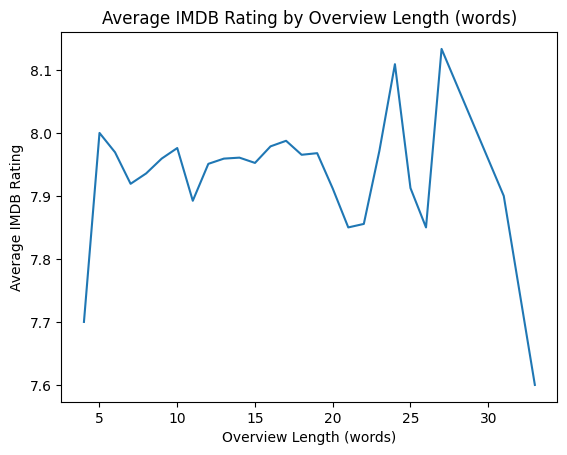

In [8]:
imdb_data.groupby("Overview_length_words")["IMDB_Rating"].mean().plot()
plt.title("Average IMDB Rating by Overview Length (words)")
plt.xlabel("Overview Length (words)")
plt.ylabel("Average IMDB Rating")
plt.show()

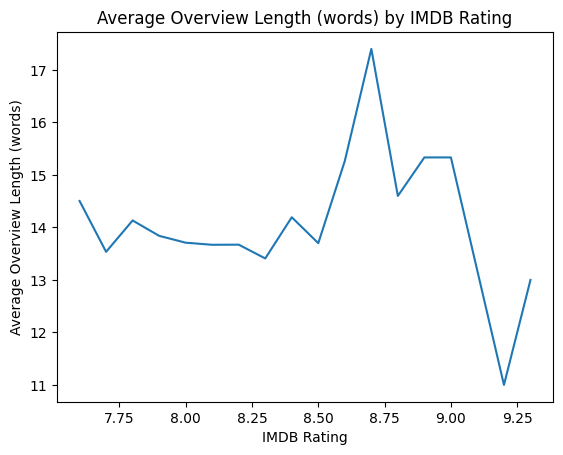

In [15]:
imdb_data.groupby("IMDB_Rating")["Overview_length_words"].mean().plot()
plt.title("Average Overview Length (words) by IMDB Rating")
plt.xlabel("IMDB Rating")
plt.ylabel("Average Overview Length (words)")
plt.show()

<Axes: xlabel='Overview_length_words', ylabel='IMDB_Rating'>

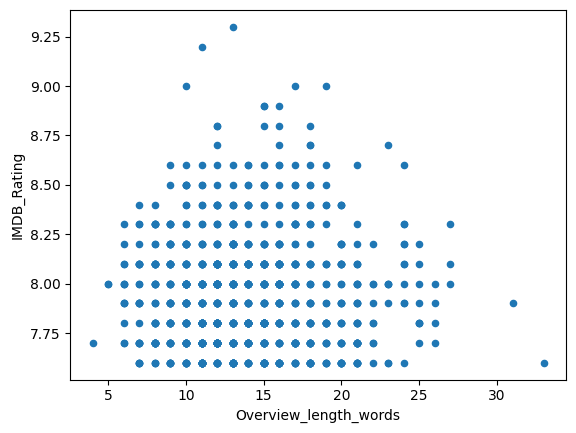

In [9]:
imdb_data.plot.scatter(x="Overview_length_words", y="IMDB_Rating")

We use spearman correlation to compare the rating with the length, as it allows for the use of discrete variables.

In [ ]:
correlation = stats.spearmanr(
    imdb_data["Overview_length_words"], imdb_data["IMDB_Rating"]
)
print(
    f"Spearman correlation between overview length and IMDB rating: {correlation.correlation:.4f} (p-value: {correlation.pvalue:.4f})"
)

Spearman correlation between overview length and IMDB rating: -0.0110 (p-value: 0.7294)


There is virtually no correlation between the length of the overview in words and the IMDB rating. The plot of the average rating per length shows there is no consistent increase or decrease of rating with overview length in words.

##### Meta score

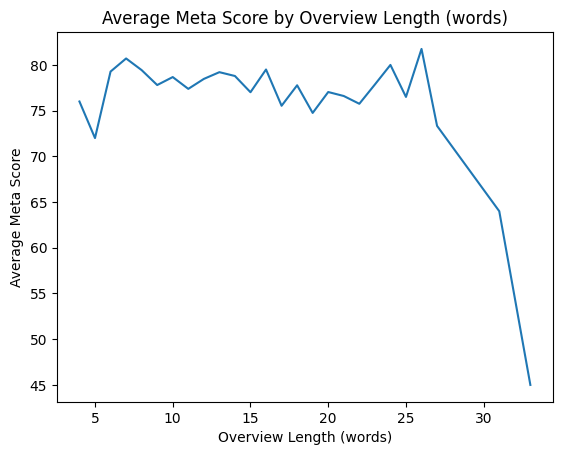

In [9]:
imdb_data.groupby("Overview_length_words")["Meta_score"].mean().plot()
plt.title("Average Meta Score by Overview Length (words)")
plt.xlabel("Overview Length (words)")
plt.ylabel("Average Meta Score")
plt.show()

We will start by dropping the entries that don't have a Meta Score.

<Axes: xlabel='Overview_length_words', ylabel='Meta_score'>

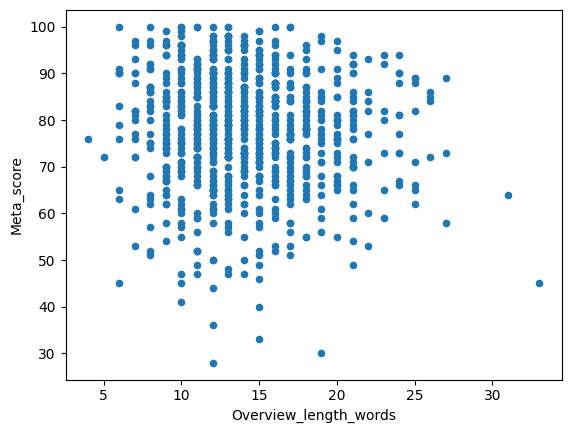

In [19]:
imdb_data_meta_score = imdb_data.dropna(subset=["Meta_score"])

imdb_data_meta_score.plot.scatter(x="Overview_length_words", y="Meta_score")

In [20]:
correlation = stats.spearmanr(
    imdb_data_meta_score["Overview_length_words"], imdb_data_meta_score["Meta_score"]
)
print(
    f"Spearman correlation between overview length and Meta score: {correlation.correlation:.4f} (p-value: {correlation.pvalue:.4f})"
)

Spearman correlation between overview length and Meta score: -0.0636 (p-value: 0.0649)


Virtually o correlation is found between the overview length in words and the Meta score.

#### 3.3.2 Length by number of characters

In [22]:
imdb_data["Overview_length_chars"] = imdb_data["Overview_processed"].apply(lambda x: sum(len(word) for word in x))

<Axes: >

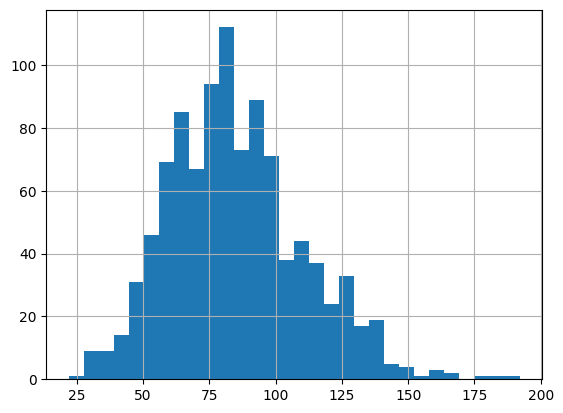

In [23]:
imdb_data["Overview_length_chars"].hist(bins=30)


Most overviews have around 77 character after stopword removal. Now exploring the relationship to ratings and scores:

##### Movie rating

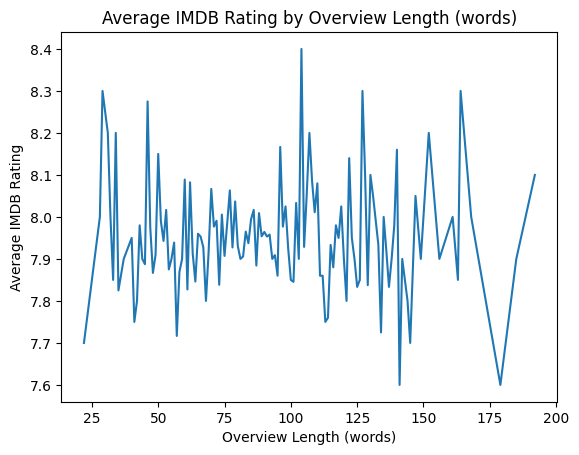

In [24]:
imdb_data.groupby("Overview_length_chars")["IMDB_Rating"].mean().plot()
plt.title("Average IMDB Rating by Overview Length (words)")
plt.xlabel("Overview Length (words)")
plt.ylabel("Average IMDB Rating")
plt.show()

<Axes: xlabel='Overview_length_chars', ylabel='IMDB_Rating'>

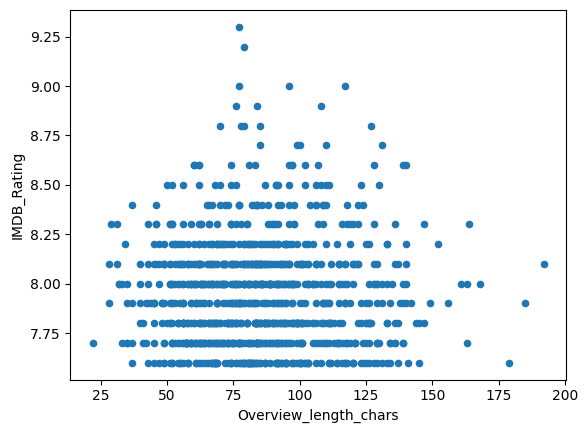

In [32]:
imdb_data.plot.scatter(x="Overview_length_chars", y="IMDB_Rating")

In [ ]:
Meta_scorecorrelation = stats.spearmanr(
    imdb_data["Overview_length_chars"], imdb_data["IMDB_Rating"]
)
print(
    f"Spearman correlation between overview length and Meta score: {correlation.correlation:.4f} (p-value: {correlation.pvalue:.4f})"
)

Spearman correlation between overview length and Meta score: -0.0068 (p-value: 0.8289)


##### Meta score

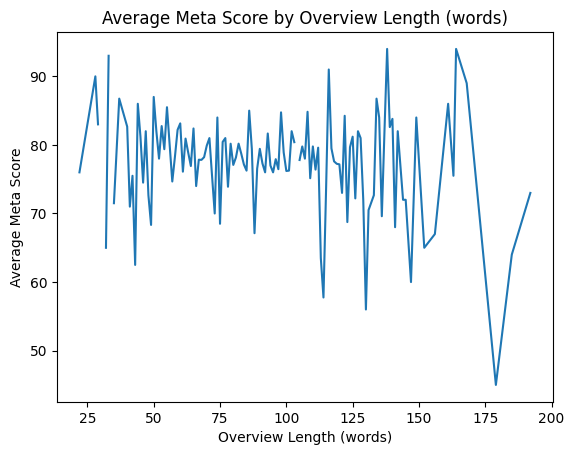

In [13]:
imdb_data.groupby("Overview_length_chars")["Meta_score"].mean().plot()
plt.title("Average Meta Score by Overview Length (words)")
plt.xlabel("Overview Length (words)")
plt.ylabel("Average Meta Score")
plt.show()

<Axes: xlabel='Overview_length_chars', ylabel='Meta_score'>

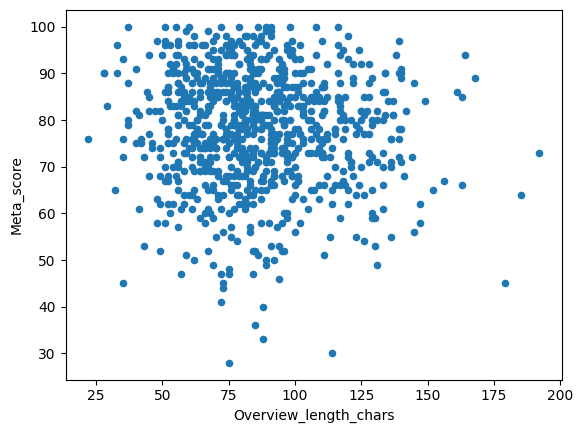

In [31]:
imdb_data_meta_score = imdb_data.dropna(subset=["Meta_score"])

imdb_data_meta_score.plot.scatter(x="Overview_length_chars", y="Meta_score")

In [30]:
correlation = stats.spearmanr(
    imdb_data_meta_score["Overview_length_chars"], imdb_data_meta_score["Meta_score"]
)
print(
    f"Spearman correlation between overview length and Meta score: {correlation.correlation:.4f} (p-value: {correlation.pvalue:.4f})"
)

Spearman correlation between overview length and Meta score: -0.0552 (p-value: 0.1095)


We again find no significant correlation between overview length in number of characters and movie ratings.